In [1]:
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.stats import chi2, ksone, gamma

from radardetseval.visualization.plot_polyline import plot_polyline, plot_polyline_range_rates
from radardetseval.visualization.plot_sensor import plot_sensor
from radardetseval.visualization.plot_point import plot_point
from radardetseval.visualization.plot_detection import plot_detection_scs
from radardetseval.visualization.utilities import publish_reduced_labels
from radardetseval.utilities.ecdf import ecdf



Bad key "text.kerning_factor" on line 4 in
c:\users\lz7c3c\wkspaces\aspe0000_00_common\sandbox\radardetectionsevaluation\.venv_pe\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load data

In [2]:
data_paths = {'velocity equal to 0': r'private\sim_line_middle_and_end_out_vel_0.pickle',
              'velocity x equal to 4': r'private\sim_line_middle_and_end_out_vel_4.pickle',
              'velocity inline with azimuth': r'private\sim_line_middle_and_end_out_vel_inline_with_azimuth.pickle',
              'velocity perp to azimuth': r'private\sim_line_middle_and_end_out_vel_perp_to_azimuth.pickle',
              'segment inline with azimuth': r'private\sim_line_middle_and_end_out_segment_inline_with_azimuth.pickle',
              'segment perp to azimuth': r'private\sim_line_middle_and_end_out_segment_perp_to_azimuth.pickle',
              'velocity x equal to 40': r'private\sim_line_middle_and_end_out_vel_40.pickle'
             }
n_samples = 10000
data_dict = dict()
for key, data_path in data_paths.items():
    
    with open(data_path, 'rb') as handle:
        data_dict[key] = pickle.load(handle)

### Compare distributions

In [3]:
def visualize_distributions(data_dict, sim_data_name, k, n_samples, data_filter=None):
    chi2_dof = [2.0, 2.5, 3.0]  # 3 variables so 3 degree of freedom
    xmax = 20
    alpha = 0.05
    x_ref = np.linspace(0, xmax, 1000)
    
    ks_test_critical_value = ksone.ppf(1-alpha/2, n_samples)
    ks_line_x = np.array([0, xmax, np.nan, 0, xmax])
    ks_line_y = np.array([ks_test_critical_value, ks_test_critical_value, np.nan, 
                          -ks_test_critical_value, -ks_test_critical_value])
    
    alpha_gamma = n_samples * k / 2.0
    theta_gamma  = 2.0 / n_samples
    mean_low_thr = gamma.ppf(alpha/2, a=alpha_gamma, scale=theta_gamma)
    mean_up_thr = gamma.ppf(1-alpha/2, a=alpha_gamma, scale=theta_gamma)
    
    data_len = len(data_dict)
    mean_ci_line_x = np.array([0, data_len, np.nan, 0, data_len]) - 0.5
    mean_ci_line_y = np.array([mean_low_thr, mean_low_thr, np.nan, mean_up_thr, mean_up_thr])
    
    plt.subplot(3, 1, 1)
   
    for key, data in data_dict.items():
        df = data[sim_data_name]
        if data_filter is not None:
            df = data_filter(df)
            
        x_ecdf, y_ecdf = ecdf(df['nees_value'])
        plt.plot(x_ecdf, y_ecdf, label=key)
        
    for dof in chi2_dof:
        y_ref_cdf = chi2.cdf(x_ref, dof)
        plt.plot(x_ref, y_ref_cdf, label=f'Chi-square with k = {dof:.1f}')

    plt.ylabel('Quantile [-]')
    plt.title('NEES cumulative distribution of simulated detection')
    plt.grid()
    plt.legend()
    
    plt.subplot(3, 1, 2)
    for key, data in data_dict.items():
        df = data[sim_data_name]
        if data_filter is not None:
            df = data_filter(df)
            
        x_ecdf, y_ecdf = ecdf(df['nees_value'])
        y_ref_ecdf = chi2.cdf(x_ecdf, k)
        ecdf_diff = y_ecdf - y_ref_ecdf
        plt.plot(x_ecdf, ecdf_diff, label=key)
    plt.plot(ks_line_x, ks_line_y, label = f'KS-test critical value with alpha = {alpha:.2f}')
    plt.xlabel('NEES value [-]')
    plt.ylabel('CDF difference [-]')
    plt.grid()
    plt.legend()
    plt.xlim([0, xmax])
    plt.title(f'Difference between empirical and reference Chi-square cumulative distribution with k= {k:.1f}')
    
    plt.subplot(3, 1, 3)    
    means = dict()
    for key, data in data_dict.items():
        df = data[sim_data_name]
        if data_filter is not None:
            df = data_filter(df)
            
        means[key] = df['nees_value'].mean()
    x_values = np.arange(len(means)) 
    x_ticks = list(means.keys())
    x_ticks = [sinlge_str.replace(' ', '\n', 1) for sinlge_str in x_ticks]
    plt.bar(x_values, list(means.values()))
    plt.xticks(x_values, x_ticks) 
    plt.plot(mean_ci_line_x, mean_ci_line_y, 'r', label = f'{(1-alpha)*100:.0f}% confidence interval for k= {k:.1f}')
    plt.ylabel('NEES mean')
    plt.grid()
    plt.legend()
    plt.title(f'Estimating k parameter of Chi-square distribution')   

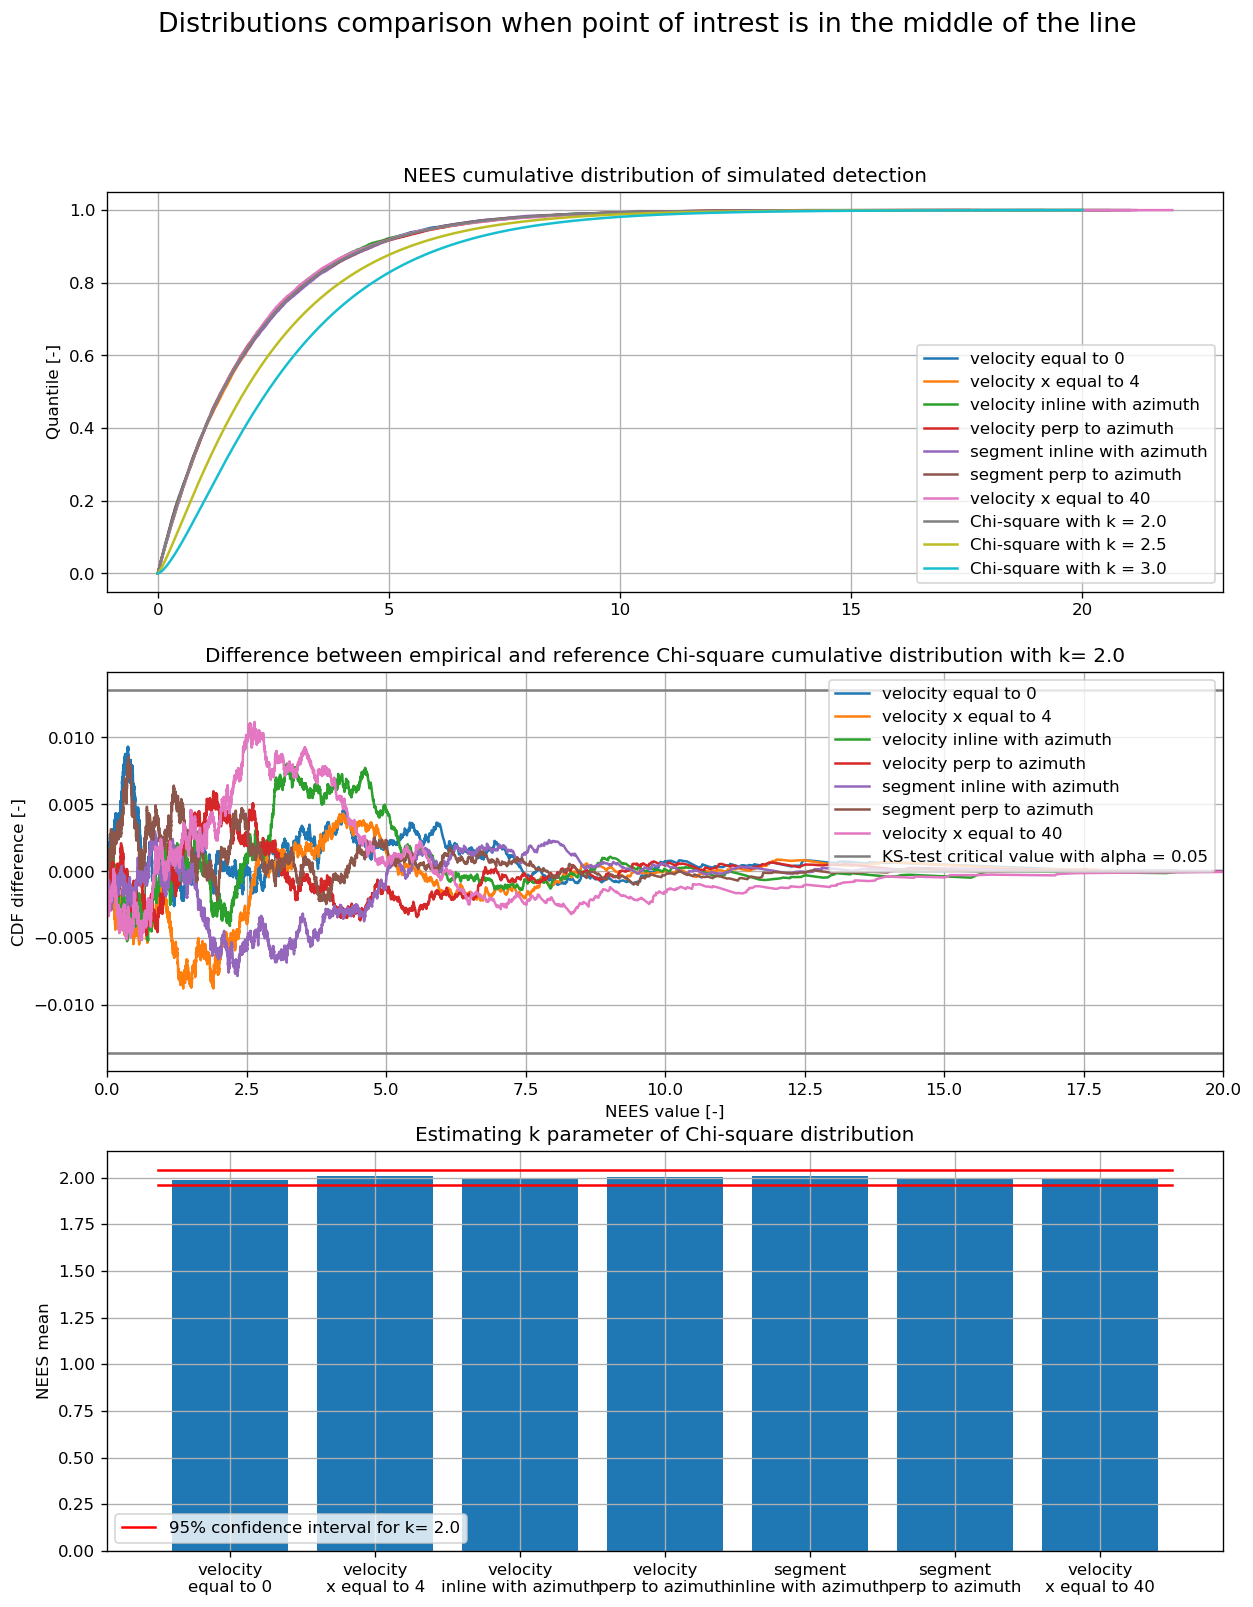

In [4]:
fig3=plt.figure(figsize=(12, 15), dpi= 120, facecolor='w', edgecolor='k')
fig3.suptitle('Distributions comparison when point of intrest is in the middle of the line', fontsize=16)
visualize_distributions(data_dict, 'sim_out_middle_df', 2.0, n_samples)

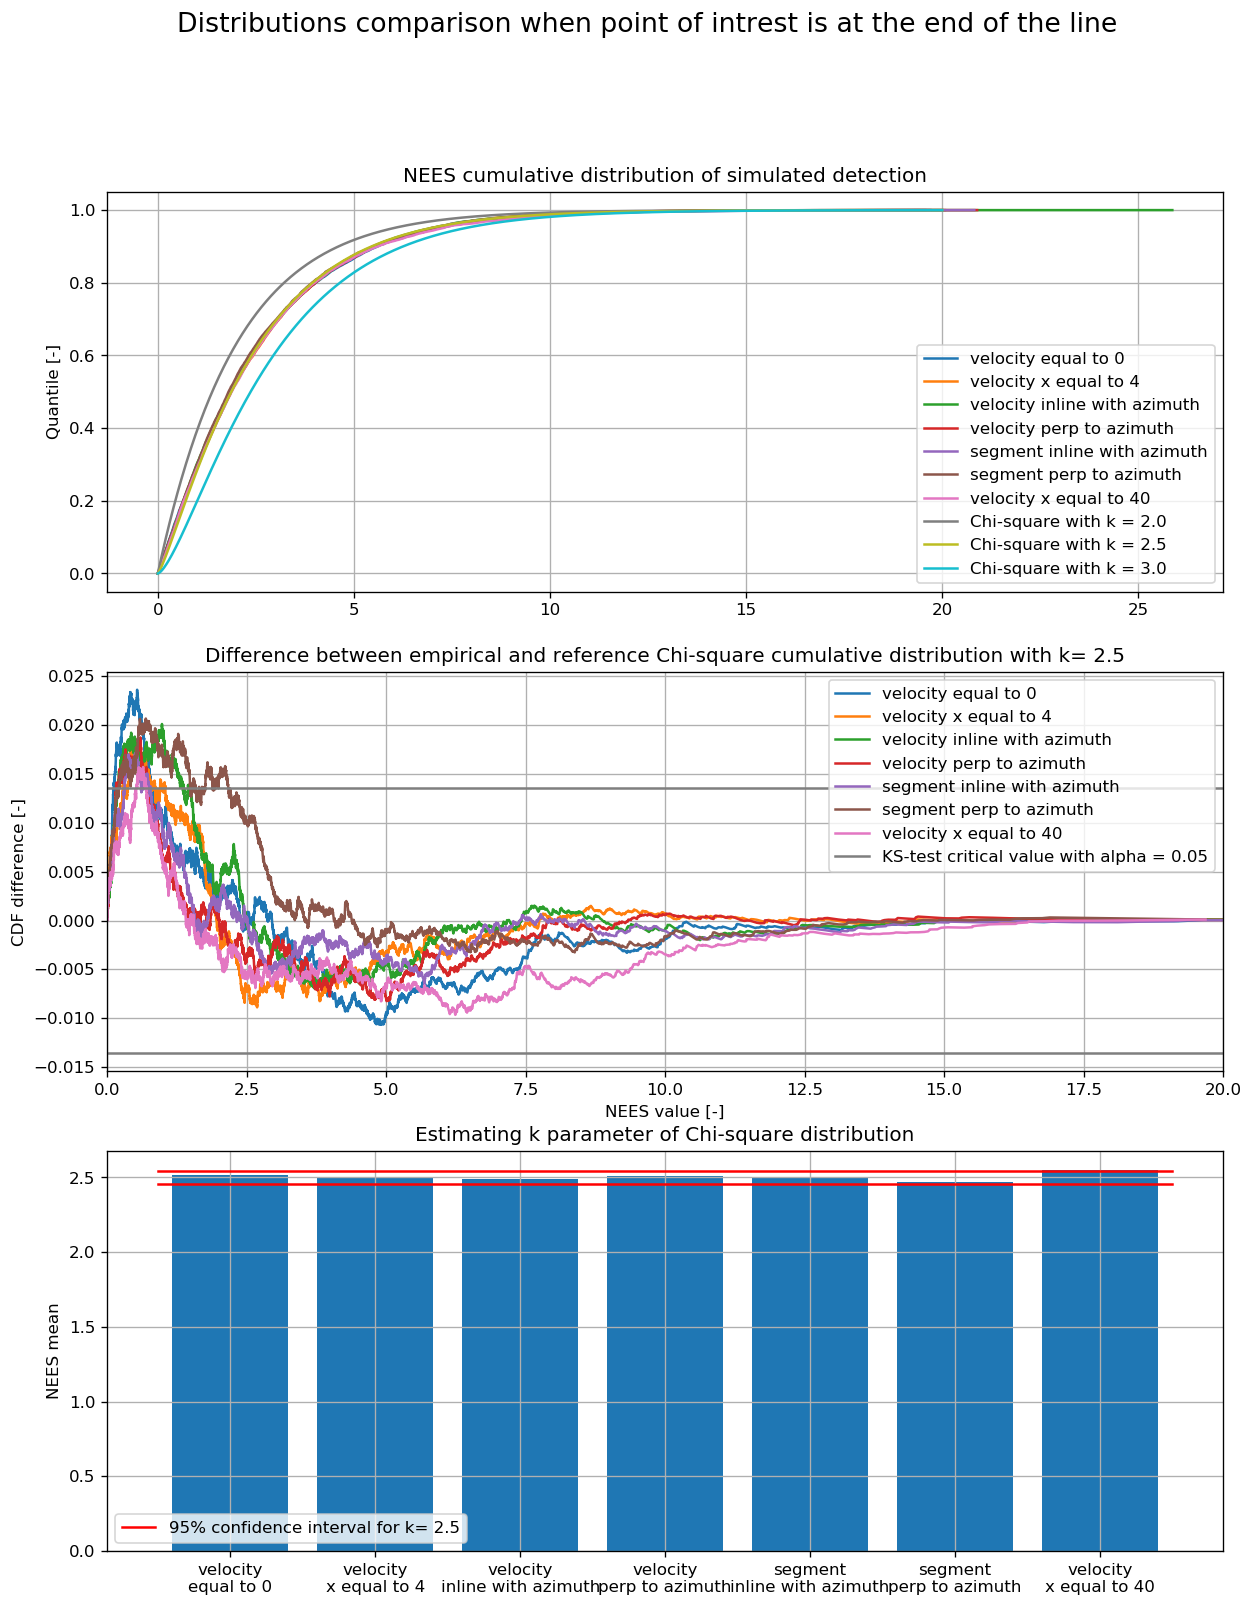

In [5]:
fig4=plt.figure(figsize=(12, 15), dpi= 120, facecolor='w', edgecolor='k')
fig4.suptitle('Distributions comparison when point of intrest is at the end of the line', fontsize=16) 
visualize_distributions(data_dict, 'sim_out_end_df', 2.5, n_samples)

In [6]:
def data_filter_corner(df):
    corner = df.vertex_id < 0.001
    corner_df = df[corner]
    return corner_df

def data_filter_not_corner(df):
    corner = df.vertex_id < 0.001
    not_corner_df = df[np.logical_not(corner)]
    return not_corner_df

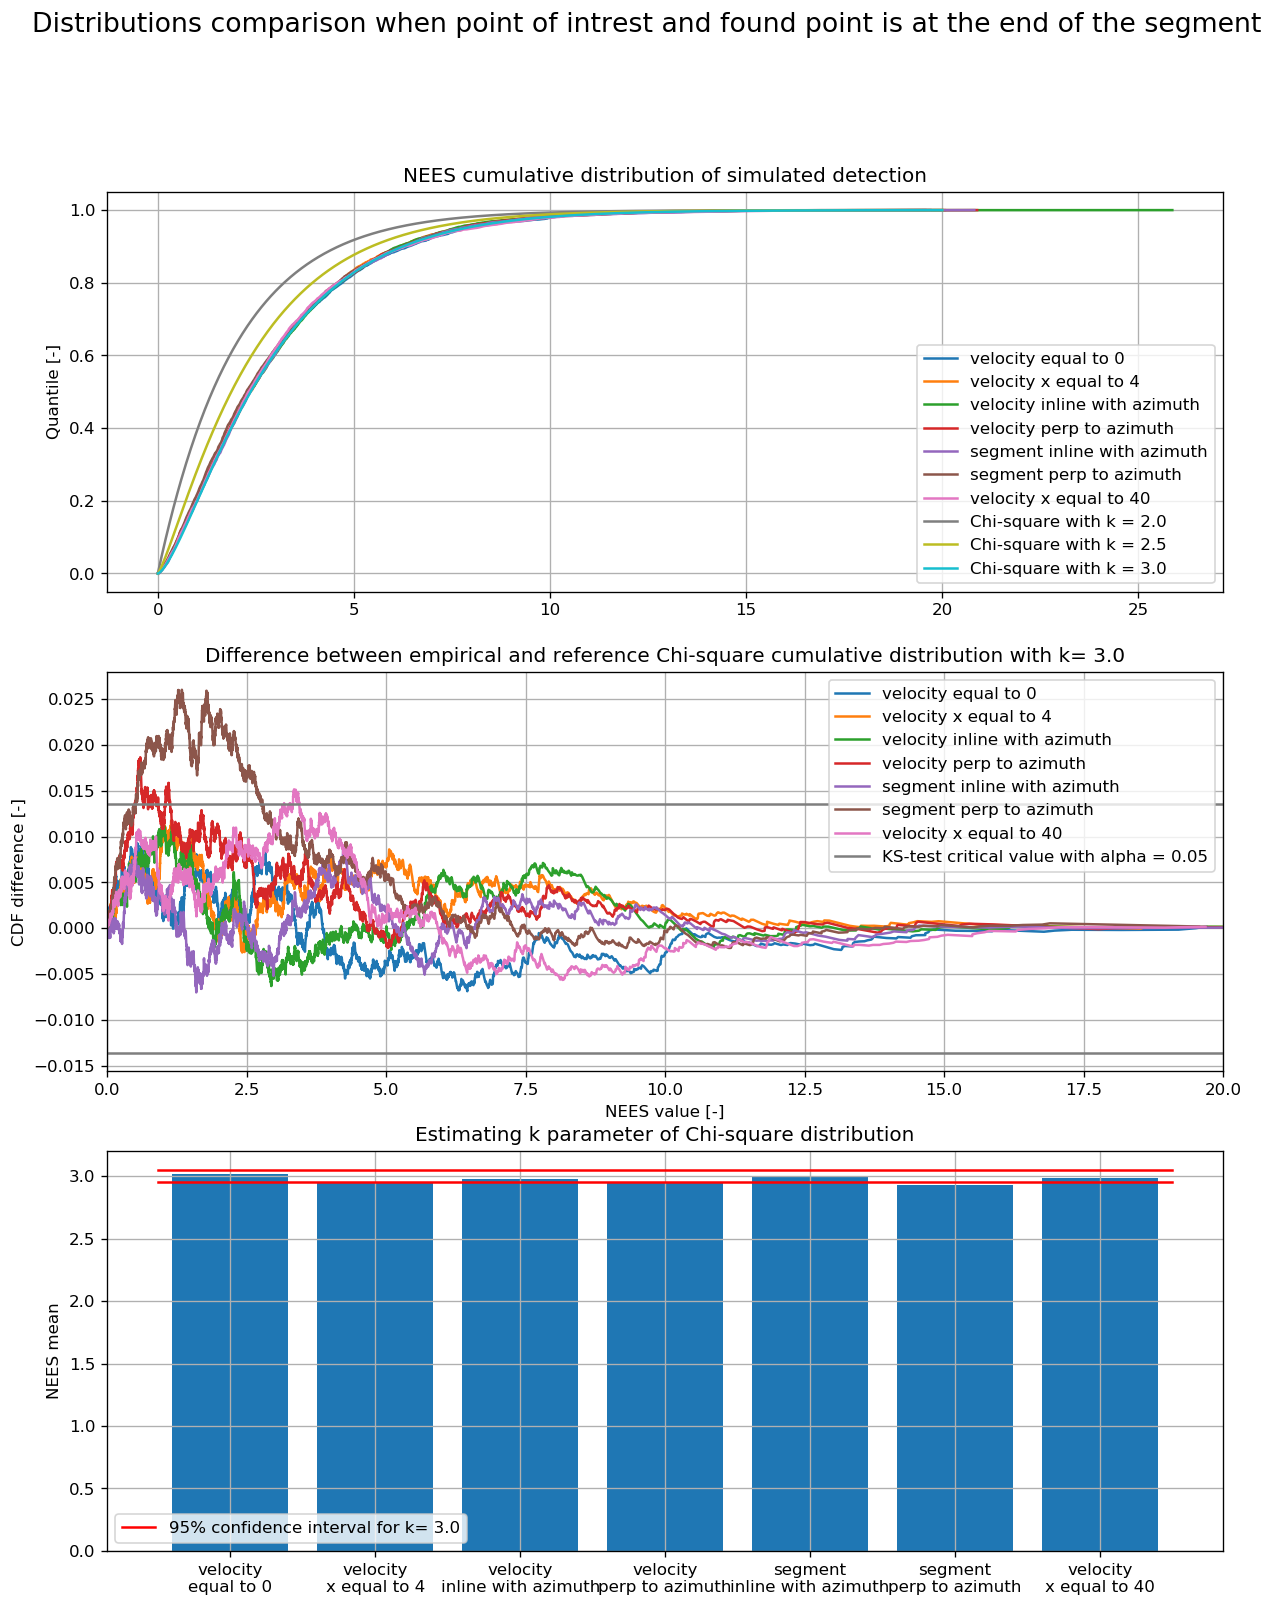

In [7]:
fig=plt.figure(figsize=(12, 15), dpi= 120, facecolor='w', edgecolor='k')
fig.suptitle('Distributions comparison when point of intrest and found point is at the end of the segment', fontsize=16) 
visualize_distributions(data_dict, 'sim_out_end_df', 3.0, n_samples, data_filter_corner)

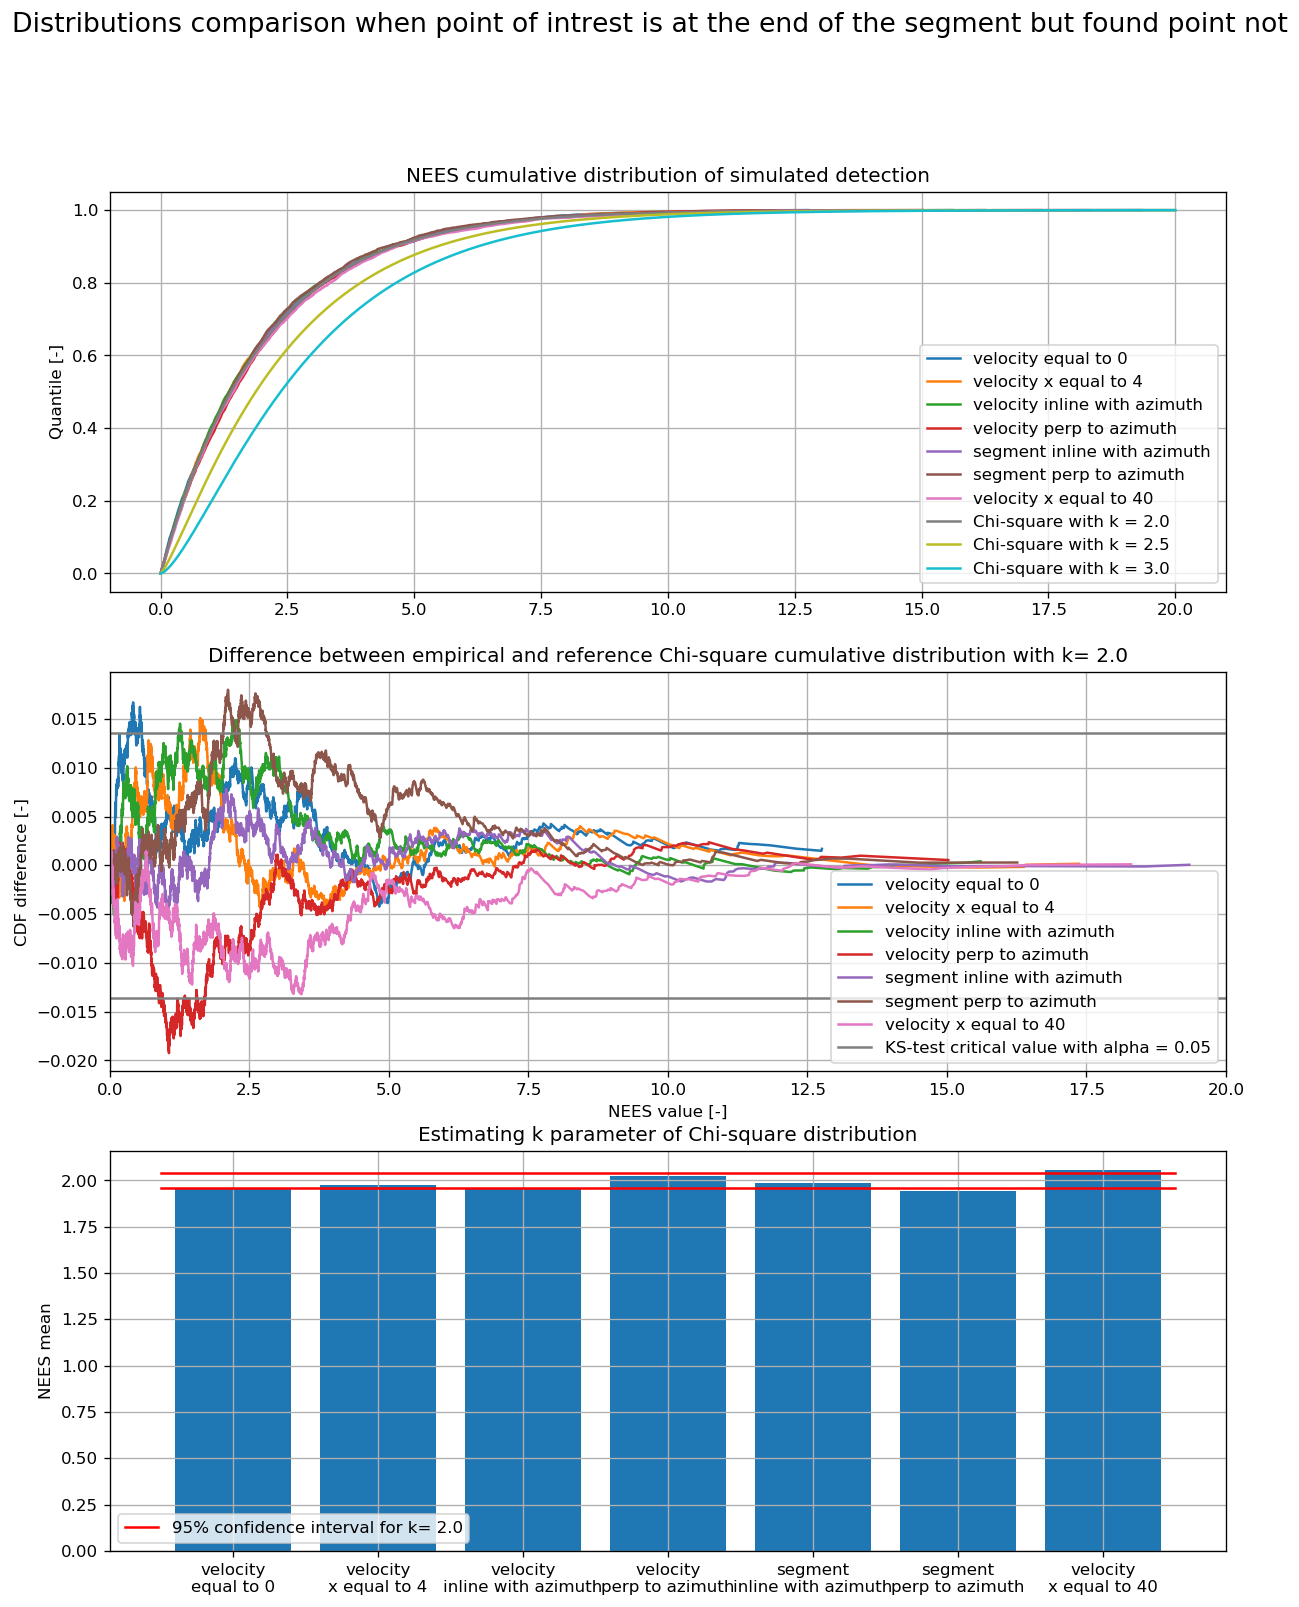

In [8]:
fig=plt.figure(figsize=(12, 15), dpi= 120, facecolor='w', edgecolor='k')
fig.suptitle('Distributions comparison when point of intrest is at the end of the segment but found point not', fontsize=16) 
visualize_distributions(data_dict, 'sim_out_end_df', 2.0, n_samples, data_filter_not_corner)